In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
segments = gpd.read_file('segmentacion_general_san_martin.geojson')
segments.rename(columns={'name':'area', 'description':'region'},inplace=True)

props = pd.read_csv('https://raw.githubusercontent.com/nvrancovich/san_martin_propiedades_geodatos/main/features_propiedades_4371.csv', index_col=0)
props = gpd.GeoDataFrame(props, geometry=gpd.points_from_xy(props.longitude, props.latitude))
props = props.set_crs('EPSG:4326')


df = props.sjoin(segments, how='inner')
df.drop(columns = ['index_right','region','geometry'], inplace=True)
df['price/m2'] = df.price_USD / df.covered_surface_m2

segments_avg = df.groupby('area').mean()[['covered_surface_m2', 'antiquity', 'price_USD', 'price/m2']].reset_index(level=0)
df.drop(labels='price/m2', axis=1, inplace=True)
segments_avg = segments_avg[['area','price/m2']]
segments_avg = segments_avg.set_index('area')

df = df.join(segments_avg, how='inner',on='area')

df['bathrooms'] = df['bathrooms'].fillna(1)
df.dropna(subset=['bedrooms'], axis=0, inplace=True)
df.dropna(subset=['latitude'], axis=0, inplace=True)
df.dropna(subset=['covered_surface_m2'], axis=0, inplace=True)
df.dropna(subset=['price_USD'], axis=0, inplace=True)
df = df[['price_USD','type','covered_surface_m2','bedrooms','price/m2','bathrooms','latitude','longitude']]
df.reset_index(drop=True, inplace=True)

In [26]:
df.sample(5)

,price_USD,type,covered_surface_m2,bedrooms,price/m2,bathrooms,latitude,longitude
1413,88000.0,departamento,43.0,1.0,1767.856820,1.0,-34.575733,-58.531967
1530,65000.0,departamento,42.0,1.0,1767.856820,1.0,-34.572060,-58.535330
838,350000.0,casa,290.0,5.0,1720.927167,2.0,-34.548540,-58.561370
56,155000.0,departamento,70.0,2.0,2217.485589,2.0,-34.545593,-58.553432
1571,140000.0,departamento,58.0,2.0,1767.856820,2.0,-34.574280,-58.537174


In [27]:
df.to_csv('features_propiedades_final.csv')

In [4]:
df = pd.get_dummies(df, columns=['type'])

In [5]:
df.corr().price_USD

price_USD             1.000000
covered_surface_m2    0.771365
bedrooms              0.573037
price/m2              0.156323
bathrooms             0.647871
latitude              0.026302
longitude             0.034955
type_casa             0.453606
type_departamento    -0.295035
type_ph              -0.174588
Name: price_USD, dtype: float64

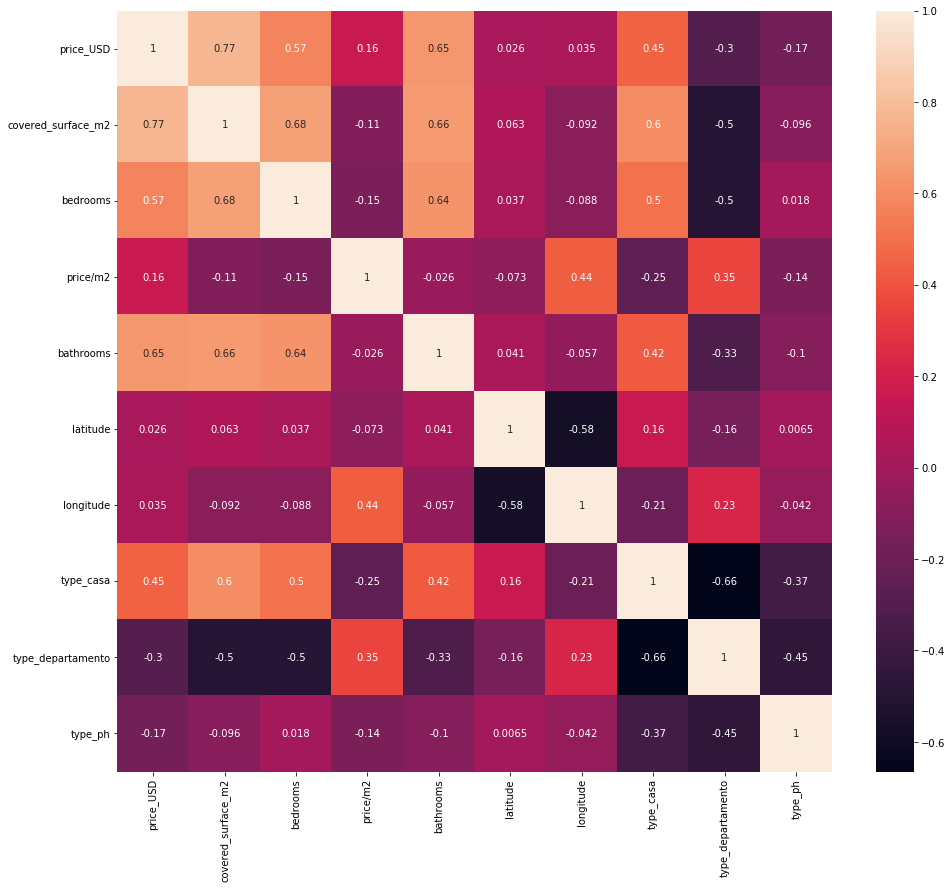

In [6]:
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), annot=True)

In [7]:
df = df[df.corr().columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3339 entries, 0 to 3338
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_USD           3339 non-null   float64
 1   covered_surface_m2  3339 non-null   float64
 2   bedrooms            3339 non-null   float64
 3   price/m2            3339 non-null   float64
 4   bathrooms           3339 non-null   float64
 5   latitude            3339 non-null   float64
 6   longitude           3339 non-null   float64
 7   type_casa           3339 non-null   uint8  
 8   type_departamento   3339 non-null   uint8  
 9   type_ph             3339 non-null   uint8  
dtypes: float64(7), uint8(3)
memory usage: 192.5 KB


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
import numpy as np

In [9]:
def split_data (df):
    X = df.drop('price_USD', axis=1)
    y = df.loc[:, ['price_USD']]
    return train_test_split(X, y, test_size=0.3, random_state=3)

In [10]:
def random_forest_regression (df):
    X_train, X_test, y_train, y_test = split_data(df)

    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_scaled = sc_X.fit_transform(X_train)
    y_scaled = sc_y.fit_transform(np.array(y_train).reshape(-1,1))

    regressor_rf = RandomForestRegressor(random_state=10, bootstrap=False, criterion= "squared_error", max_depth= None, max_features= "sqrt", n_estimators= 1000)

    y_pred_rf_train = cross_val_predict(regressor_rf, X_train, np.array(y_train).ravel(), cv=10)
    RMSE_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
    R2_rf_train = r2_score(y_train, y_pred_rf_train)
    MAE_rf_train = mean_absolute_error(y_train, y_pred_rf_train)

    y_pred_rf_test = cross_val_predict(regressor_rf, X_test, np.array(y_test).ravel(), cv=10)
    RMSE_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
    R2_rf_test = r2_score(y_test, y_pred_rf_test)
    MAE_rf_test = mean_absolute_error(y_test, y_pred_rf_test)

    print('RMSE (train): ', RMSE_rf_train)
    print('RMSE (test): ', RMSE_rf_test)
    print('R2 Score (train): ', R2_rf_train)
    print('R2 Score (test): ', R2_rf_test)
    print('MAE (train): ', MAE_rf_train)
    print('MAE (test): ', MAE_rf_test)
 
    return regressor_rf

In [11]:
regressor_rf = random_forest_regression(df)

RMSE (train):  40727.06968008659
RMSE (test):  45508.42843653621
R2 Score (train):  0.7562127789112111
R2 Score (test):  0.6897982142977965
MAE (train):  26302.791875481387
MAE (test):  28102.043776922343


In [12]:
X = df.drop('price_USD', axis=1)
y = df.loc[:, ['price_USD']]
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X)
y_scaled = sc_y.fit_transform(np.array(y).reshape(-1,1))

In [13]:
regressor_rf.fit(X_scaled, y_scaled.ravel())

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=1000,
                      random_state=10)

In [23]:
import joblib

joblib.dump(regressor_rf, "regressor_rf.joblib", compress=3)

['regressor_rf.joblib']